In [7]:
import pandas as pd
data=pd.read_csv('banladesh.csv',index_col='ObservationDate',parse_dates=True)
data.head()

,Confirmed
ObservationDate,
2020-03-08,3
2020-03-09,3
2020-03-10,3
2020-03-11,3
2020-03-12,3


In [8]:
import math
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,LSTM
from tensorflow.keras.initializers import GlorotUniform, HeNormal
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(101)


In [9]:
def train_test_split(data,n_test):
    return data[:-n_test],data[-n_test:]

def series_to_supervised(data,n_in,n_out=1):
    df=pd.DataFrame(data)
    cols=list()

    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
    
    for i in range(0,n_out):
        cols.append(df.shift(-i))
    
    agg=pd.concat(cols,axis=1)
    agg.dropna(inplace=True)
    #print(agg.head(5))

    return agg.values
def difference(data,interval):
    return [data[i]-data[i-interval] for i in range(interval,len(data))]

def model_fit(train,config):

    n_input, n_nodes, n_epochs, n_batch,n_diff= config

    if n_diff>0:
        train=difference(train,n_diff)

    data=series_to_supervised(train,n_input)
    
    train_x, train_y=data[:,:-1],data[:,-1]
    #print(train_x.shape)
    train_x=train_x.reshape((train_x.shape[0],train_x.shape[1],1))

    model=Sequential()
    model.add(LSTM(n_nodes,activation='relu',input_shape=(n_input,1),kernel_initializer=HeNormal()))
    model.add(Dense(n_nodes,activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse',optimizer='adam')

    model.fit(train_x,train_y,epochs=n_epochs, batch_size=n_batch,verbose=0)
    return model

def model_predict(model,history,config):
    n_input,_,_,_,n_diff=config
    
    correction=0.0
    if n_diff>0:
        correction=history[-n_diff]
        history=difference(history,n_diff)

    x_input=np.array(history[-n_input:]).reshape((1,n_input,1))
    #print(x_input)
    y_hat=model.predict(x_input,verbose=0)
    return correction + y_hat[0].round()

def measure_rmse(actual,prediction):
    return math.sqrt(metrics.mean_squared_error(actual,prediction,squared=False))

def walk_forward_validation(data,n_test,cfg):
    predictions=list()
    train,test=train_test_split(data,n_test)

    model=model_fit(train,cfg)

    history=[x for x in train]
    
    for i in range(len(test)):
        yhat=model_predict(model,history,cfg)
        predictions.append(yhat.round())
        history.append(test[i])
    error=measure_rmse(test,predictions)
    print(" > %.3f " %error)
    return error
def repeat_evaluate(data,config,n_test,n_repeats=5):
    scores=[walk_forward_validation(data,n_test,config) for _ in range(int(n_repeats))]
    return scores
def summarize_scores(name,scores):
    scores_m, score_std= np.mean(scores), np.std(scores)
    print("%s: %.3f RMSE (+/- %3f" %(name,scores_m,score_std))
    plt.boxplot(scores)
    plt.show()


In [10]:
data=data.values

### without round the number averge is 192.466 and variation is 13.84

 > 153.773 
 > 200.247 
 > 126.992 
 > 1339.262 
 > 425.106 
Persistence: 449.076 RMSE (+/- 457.354119


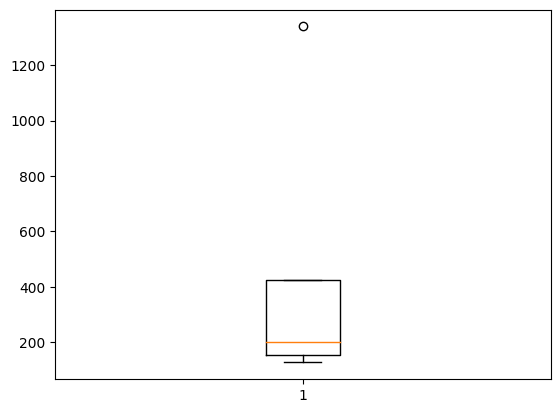

In [11]:
n_test=164
config=[12,100,100,100,0]
scores=repeat_evaluate(data,config,n_test)

summarize_scores('Persistence',scores)

In [13]:
tensorflow.random.set_seed(105)
n_test=164
config=[6,50,100,100,0]
predictions=list()
train,test=train_test_split(data,n_test)

model=model_fit(train,config)

history=[x for x in train]

for i in range(len(test)):
    yhat=model_predict(model,history,config)
    predictions.append(yhat.round())
    history.append(test[i])
error=measure_rmse(test,predictions)
print(" > %.3f " %error)

 > 95.280 


In [14]:
test_np=list()
for i in range(test.shape[0]):
    test_np.append(test[i][0])

In [15]:
prediction_np=list()
for i in range(test.shape[0]):
    prediction_np.append(predictions[i][0].round())

In [16]:
test_np=np.array(test_np)
prediction_np=np.array(prediction_np)
prediction_data=pd.DataFrame({'test':test_np,'predict':prediction_np})
prediction_data.head()

,test,predict
0,1591093,1595311.0
1,1592209,1596395.0
2,1593700,1597514.0
3,1595931,1598740.0
4,1598389,1600361.0


<Axes: >

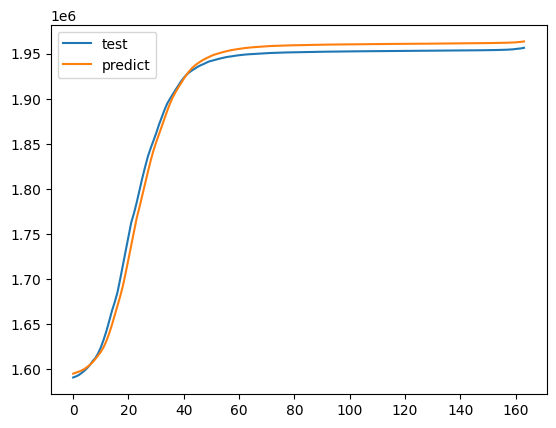

In [17]:
prediction_data.plot()

In [18]:
data_2=pd.read_csv('banladesh.csv',index_col='ObservationDate',parse_dates=True)
data_2.head()

,Confirmed
ObservationDate,
2020-03-08,3
2020-03-09,3
2020-03-10,3
2020-03-11,3
2020-03-12,3


In [19]:
new_predict=pd.concat([prediction_data,pd.DataFrame(data_2.index[-164:])],axis=1)

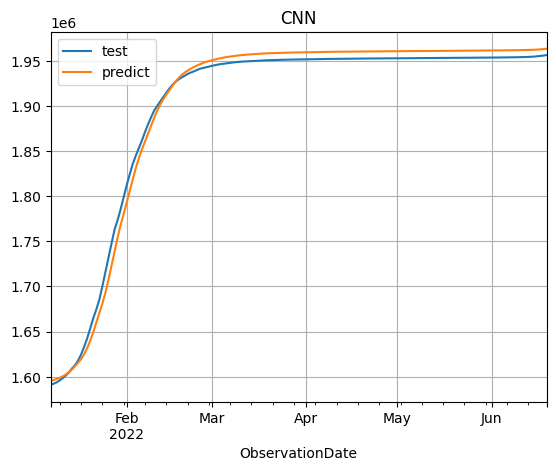

In [22]:
from matplotlib import pyplot as plt
plt.rcParams["savefig.dpi"] = 360
new_predict.plot(x='ObservationDate')
plt.title('CNN')
plt.grid()